In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('../data/raw/gmail_emails.csv')
df.head()

,sender,receivers,message
0,Gmail Team <mail-noreply@google.com>,Karthik Gnana Ezhil S <ep23btech11016@iith.ac.in>,Get the official Gmail app\n\nGet the official...
1,Gmail Team <mail-noreply@google.com>,Karthik Gnana Ezhil S <ep23btech11016@iith.ac.in>,Tips for using your new inbox\n\nTips for usin...
2,SKGEzhil <skgezhil2005@gmail.com>,"""ep23btech11016@iith.ac.in"" <ep23btech11016@ii...",\n\n\r\n
3,International Collaboration IR <ic.ir@iith.ac.in>,students@iith.ac.in,Call for applications for the Swiss Government...
4,Green Office IIT Hyderabad <office.green@iith....,"Students <students@iith.ac.in>, ""Faculty, IIT ...","Plantation drive on 05-08-2023\n\nDear All,\r\..."


In [3]:
import torch
embeddings = torch.load('../data/processed/email_embeddings.pt')

/var/folders/0h/zxphsfbn487bj2pt3jw_p7nr0000gn/T/ipykernel_91316/3855300869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('../data/processed/em

In [4]:
df['emb'] = embeddings.tolist()  # convert tensor to list for DataFrame

## Data Preparation
Label emails based on their content using SBERT embeddings and cosine similarity to predefined prototypes.

In [5]:
import numpy as np

from sentence_transformers import SentenceTransformer, util

# 2) Load SBERT and encode all emails
model = SentenceTransformer('all-MiniLM-L6-v2')

raw_prototypes = {
    # 'meeting':     ["Team sync-up meeting", "Project planning meeting"],
    # 'announcement':["Official announcement", "Please note the announcement"],
    'internship':  ["Summer internship opportunity", "Apply for internship", "Internship application deadline", "Internship program details", "Registration deadline for the internship", "Internship cell", "Placement cell", "Exchange program opportunity", "exchange program"],
    'club':        ["Student club event", "Join our club", "join the core team", "Club orientations", "Sunshine meeting invites", "shuffle conducting events", "Vibes conducting events", "milan events", "Elan and nvision", "Diesta events", "Behind the lens events", "Call for coordinators", "EBSB events"],
    'talks':       ["Guest speaker talk", "PhD viva voice announcements", "seminar on the topic", "Open colloquium", "Thesis on the topic", "Research proposal seminar", "Research seminar talks", "Invitation for seminar", "viva voice", "Upcoming talks", "Research talks", "Sessions on academics", "Upcoming events", "Event registration", "Invitation to industry lectures", "Invitation to event"],
    # 'maintenance':  ["scheduled maintenance", "Maintenance window", "Internet connection down", "Shutdown notice"],
    'academics':   ["Academic calendar", "Course registration", "Exam schedule", "Assignment deadlines", "Assignment submission"],
}
prototypes = {
    label: np.mean(
        model.encode(texts, convert_to_tensor=False),  # now returns a list of lists
        axis=0
    )
    for label, texts in raw_prototypes.items()
}



/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
# 4) Compute cosine‐similarities of each email to each prototype
sims = {
    label: util.cos_sim(proto, embeddings)[0]
    for label, proto in prototypes.items()
}

threshold = 0.4
def pick_label(i):
    # build a dict of {label: score}
    scores = {lbl: sims[lbl][i].item() for lbl in sims}
    best_label, best_score = max(scores.items(), key=lambda kv: kv[1])
    return best_label if best_score > threshold else 'other'

df['label'] = [pick_label(i) for i in range(len(df))]

# print(df)
df

,sender,receivers,message,emb,label
0,Gmail Team <mail-noreply@google.com>,Karthik Gnana Ezhil S <ep23btech11016@iith.ac.in>,Get the official Gmail app\n\nGet the official...,"[-0.09933263063430786, 0.001328121405094862, 0...",other
1,Gmail Team <mail-noreply@google.com>,Karthik Gnana Ezhil S <ep23btech11016@iith.ac.in>,Tips for using your new inbox\n\nTips for usin...,"[-0.050356633961200714, 0.06010790541768074, -...",other
2,SKGEzhil <skgezhil2005@gmail.com>,"""ep23btech11016@iith.ac.in"" <ep23btech11016@ii...",\n\n\r\n,"[-0.11883833259344101, 0.0482986718416214, -0....",other
3,International Collaboration IR <ic.ir@iith.ac.in>,students@iith.ac.in,Call for applications for the Swiss Government...,"[-0.09319693595170975, 0.01009377185255289, -0...",other
4,Green Office IIT Hyderabad <office.green@iith....,"Students <students@iith.ac.in>, ""Faculty, IIT ...","Plantation drive on 05-08-2023\n\nDear All,\r\...","[-0.04429999738931656, -0.015538915991783142, ...",other
...,...,...,...,...,...
18946,Shiv Govind Singh <sgsingh@ee.iith.ac.in>,"""EE, Seminar"" <seminar@ee.iith.ac.in>, ""Ph.D. ...","PhD Vivo-Voce (online) of Ghosh Tanmoya , 2.30...","[-0.10579375177621841, -0.015991903841495514, ...",other
18947,Japandesk IR <japandesk.ir@iith.ac.in>,Students <students@iith.ac.in>,Re: BTech only : The University of Tokyo Sakur...,"[-0.11099039763212204, -0.015269726514816284, ...",academics
18948,TechGig Webinar <expertspeak@techgig.com>,ep23btech11016@iith.ac.in,How UiPath Autopilot is Redefining Developer P...,"[-0.018514640629291534, -0.06346655637025833, ...",other
18949,"""'Cultural Secretary' via Students, IIT Hydera...",Students <students@iith.ac.in>,Re: Join the Shuffle Club’s Online Dance Reel ...,"[-0.10851454734802246, -0.05394021049141884, 0...",club


In [7]:
df.groupby('label').count()


,sender,receivers,message,emb
label,,,,
academics,1577,1551,1577,1577
club,1179,1179,1179,1179
internship,713,711,713,713
other,14420,14289,14420,14420
talks,1062,1061,1062,1062


In [8]:
# create new DataFrame with only the selected labels
selected = ['academics', 'talks', 'internship', 'club', 'other']
new_df = df[df['label'].isin(selected)].copy()
new_df

,sender,receivers,message,emb,label
0,Gmail Team <mail-noreply@google.com>,Karthik Gnana Ezhil S <ep23btech11016@iith.ac.in>,Get the official Gmail app\n\nGet the official...,"[-0.09933263063430786, 0.001328121405094862, 0...",other
1,Gmail Team <mail-noreply@google.com>,Karthik Gnana Ezhil S <ep23btech11016@iith.ac.in>,Tips for using your new inbox\n\nTips for usin...,"[-0.050356633961200714, 0.06010790541768074, -...",other
2,SKGEzhil <skgezhil2005@gmail.com>,"""ep23btech11016@iith.ac.in"" <ep23btech11016@ii...",\n\n\r\n,"[-0.11883833259344101, 0.0482986718416214, -0....",other
3,International Collaboration IR <ic.ir@iith.ac.in>,students@iith.ac.in,Call for applications for the Swiss Government...,"[-0.09319693595170975, 0.01009377185255289, -0...",other
4,Green Office IIT Hyderabad <office.green@iith....,"Students <students@iith.ac.in>, ""Faculty, IIT ...","Plantation drive on 05-08-2023\n\nDear All,\r\...","[-0.04429999738931656, -0.015538915991783142, ...",other
...,...,...,...,...,...
18946,Shiv Govind Singh <sgsingh@ee.iith.ac.in>,"""EE, Seminar"" <seminar@ee.iith.ac.in>, ""Ph.D. ...","PhD Vivo-Voce (online) of Ghosh Tanmoya , 2.30...","[-0.10579375177621841, -0.015991903841495514, ...",other
18947,Japandesk IR <japandesk.ir@iith.ac.in>,Students <students@iith.ac.in>,Re: BTech only : The University of Tokyo Sakur...,"[-0.11099039763212204, -0.015269726514816284, ...",academics
18948,TechGig Webinar <expertspeak@techgig.com>,ep23btech11016@iith.ac.in,How UiPath Autopilot is Redefining Developer P...,"[-0.018514640629291534, -0.06346655637025833, ...",other
18949,"""'Cultural Secretary' via Students, IIT Hydera...",Students <students@iith.ac.in>,Re: Join the Shuffle Club’s Online Dance Reel ...,"[-0.10851454734802246, -0.05394021049141884, 0...",club


In [9]:
new_df.groupby('label').count()


,sender,receivers,message,emb
label,,,,
academics,1577,1551,1577,1577
club,1179,1179,1179,1179
internship,713,711,713,713
other,14420,14289,14420,14420
talks,1062,1061,1062,1062


## Downsample the dataset to balance the classes.

In [10]:
# pick 1000 academics
acad_sample  = new_df[new_df['label']=='academics'] \
                   .sample(n=1000, random_state=42)

# pick 1000 others
other_sample = new_df[new_df['label']=='other'] \
                   .sample(n=1000, random_state=42)

# keep *all* the remaining labels (club, internship, talks, etc.)
rest         = new_df[~new_df['label'].isin(['academics','other'])]

# combine & reshuffle
downsamp_df = pd.concat([acad_sample, other_sample, rest],
                        ignore_index=True) \
              .sample(frac=1, random_state=42) \
              .reset_index(drop=True)

downsamp_df.groupby('label').size()

label
academics     1000
club          1179
internship     713
other         1000
talks         1062
dtype: int64

In [14]:
# save to a pickle
downsamp_df.to_pickle('../data/processed/downsamp_df_2.pkl')

## Training a simple neural network model
#### Creating Training and Test Sets, Encoding Labels

In [15]:
!pip install --upgrade typing_extensions

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# 1) Prepare X (embeddings) and y (labels)
# ------------------------------------------------
# assume you have your embeddings as a column of lists/arrays
# e.g. df['emb'] was set earlier via model.encode(...).tolist()
X = np.vstack(downsamp_df['emb'].values)        # shape (N, D)
y_raw = downsamp_df['label'].values             # shape (N,)

# 2) Encode labels as integers
# ------------------------------------------------
le = LabelEncoder()
y = le.fit_transform(y_raw)            # now y is 0,1,2,3,4 for your 5 classes
num_classes = len(le.classes_)

# 3) Train/test split (stratify to preserve class ratios)
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
label_to_code = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label to code mapping:", label_to_code)

Label to code mapping: {'academics': 0, 'club': 1, 'internship': 2, 'other': 3, 'talks': 4}


In [13]:
# 4) Compute class weights
# ------------------------------------------------
# this gives you an array of length num_classes
# weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(num_classes),
#     y=y_train
# )
# class_weight = {i: w for i, w in enumerate(weights)}

In [14]:
# 5) Build a simple Sequential model
# ------------------------------------------------
model = Sequential([
    layers.Input(shape=(X.shape[1],)),      # SBERT embedding size
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)


In [15]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    batch_size=32,
    verbose=1
    # class_weight=class_weight
)

Epoch 1/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5460 - loss: 1.2439 - val_accuracy: 0.8537 - val_loss: 0.4204
Epoch 2/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8532 - loss: 0.3943 - val_accuracy: 0.9031 - val_loss: 0.2688
Epoch 3/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9188 - loss: 0.2372 - val_accuracy: 0.9243 - val_loss: 0.2109
Epoch 4/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9268 - loss: 0.2111 - val_accuracy: 0.9435 - val_loss: 0.1945
Epoch 5/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9482 - loss: 0.1570 - val_accuracy: 0.9384 - val_loss: 0.1800
Epoch 6/6
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9491 - loss: 0.1457 - val_accuracy: 0.9354 - val_loss: 0.1776


In [16]:
model.evaluate(X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9378 - loss: 0.1837


[0.1775745004415512, 0.9354187846183777]

In [17]:
X_test.shape, y_test.shape, num_classes

((991, 384), (991,), 5)

### Confusion Matrix and Classification Report

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
[[195   4   1   0   0]
 [  2 226   1   4   3]
 [  2   0 140   0   1]
 [  7  10   4 167  12]
 [  7   1   1   4 199]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       200
           1       0.94      0.96      0.95       236
           2       0.95      0.98      0.97       143
           3       0.95      0.83      0.89       200
           4       0.93      0.94      0.93       212

    accuracy                           0.94       991
   macro avg       0.94      0.94      0.94       991
weighted avg       0.94      0.94      0.93       991



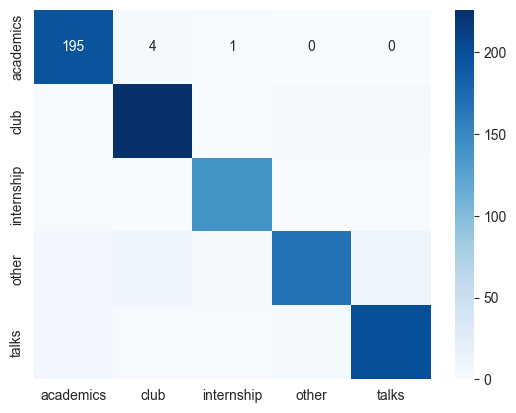

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Predict on your "test-as-validation" set
y_prob = model.predict(X_test)          # for softmax multi‑class
y_pred = np.argmax(y_prob, axis=1)

# 2) Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 3) (Optional) Print out precision/recall/f1
print(classification_report(y_test, y_pred))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.show()

#### Save the Model

In [24]:
model.save('model_v2.keras')